# Import Data and Preprocessig

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"applejin","key":"0b93924b947f72a219bb11234c07cc77"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

 93% 3.49G/3.75G [00:13<00:01, 271MB/s]

In [ ]:
!unzip 140k-real-and-fake-faces.zip

Archive:  140k-real-and-fake-faces.zip
replace real_vs_fake/real-vs-fake/test/fake/00276TOPP4.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import glob
import pandas as pd

main_path = './real_vs_fake/real-vs-fake'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

for folder in os.listdir(main_path): #iterate on each train, valid and test folder
    for label in os.listdir(main_path + "/" + folder): #iterate on fake and real folders (labels)
        for img in glob.glob(main_path + "/" + folder + "/" + label + "/*.jpg"):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)
images_df = pd.DataFrame(images_df)
images_df

folder                                         image_path label
0       valid  ./real_vs_fake/real-vs-fake/valid/fake/CPERPCR...  fake
1       valid  ./real_vs_fake/real-vs-fake/valid/fake/KONY9IZ...  fake
2       valid  ./real_vs_fake/real-vs-fake/valid/fake/F930YSB...  fake
3       valid  ./real_vs_fake/real-vs-fake/valid/fake/KHCZZXW...  fake
4       valid  ./real_vs_fake/real-vs-fake/valid/fake/IWENY7Q...  fake
...       ...                                                ...   ...
139995  train   ./real_vs_fake/real-vs-fake/train/real/13277.jpg  real
139996  train   ./real_vs_fake/real-vs-fake/train/real/53688.jpg  real
139997  train   ./real_vs_fake/real-vs-fake/train/real/56873.jpg  real
139998  train   ./real_vs_fake/real-vs-fake/train/real/65416.jpg  real
139999  train   ./real_vs_fake/real-vs-fake/train/real/51372.jpg  real

[140000 rows x 3 columns]

In [ ]:
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import seaborn as sns
from sklearn import metrics

image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [ ]:
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [ ]:
input_shape = (256, 256, 3)

# MobileNet Training (Freeze all layers)

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# First model
# final performance is about 0.90

# Load MobileNet model without the top layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # You can adjust the number of units
predictions = Dense(1, activation='sigmoid')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Implement callbacks to prevent overfitting
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='model_best_weights.h5', monitor='val_loss', save_best_only=True)
]

# Fine-tune the model
history = model.fit(
    train_ds,
    epochs=5,  # You can adjust the number of epochs
    validation_data=valid_ds,
    callbacks=callbacks
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

Epoch 1/5
1563/1563 [==============================] - 318s 202ms/step - loss: 0.3921 - accuracy: 0.8217 - val_loss: 0.3638 - val_accuracy: 0.8381


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/5
1563/1563 [==============================] - 312s 199ms/step - loss: 0.2948 - accuracy: 0.8712 - val_loss: 0.2897 - val_accuracy: 0.8784
Epoch 3/5
1563/1563 [==============================] - 332s 212ms/step - loss: 0.2507 - accuracy: 0.8943 - val_loss: 0.2614 - val_accuracy: 0.8922
Epoch 4/5
1563/1563 [==============================] - 336s 215ms/step - loss: 0.2172 - accuracy: 0.9106 - val_loss: 0.2305 - val_accuracy: 0.9061
Epoch 5/5
313/313 [==============================] - 52s 167ms/step - loss: 0.2414 - accuracy: 0.9026
Test accuracy: 0.902649998664856, Test loss: 0.24135464429855347


313/313 [==============================] - 47s 150ms/step - loss: 0.2306 - accuracy: 0.9036
Test accuracy: 0.9035999774932861, Test loss: 0.23060618340969086
313/313 [==============================] - 53s 168ms/step


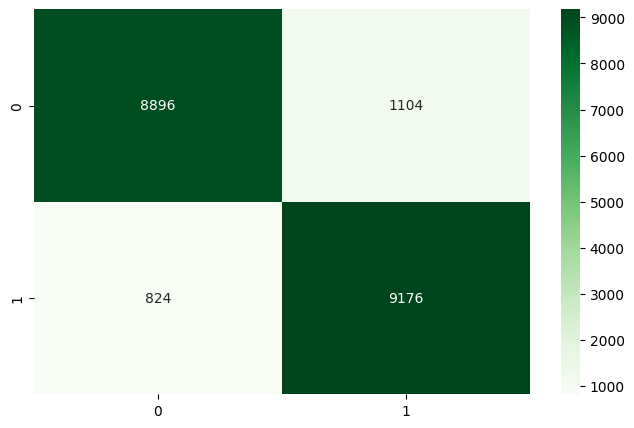

Precision: 0.8926070038910506
Recall: 0.9176
F1 Score: 0.9049309664694279


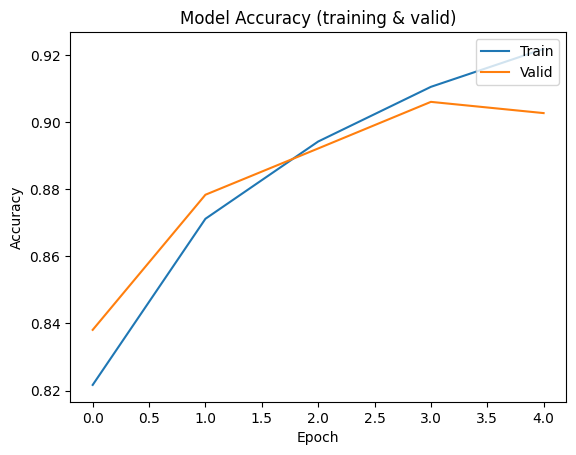

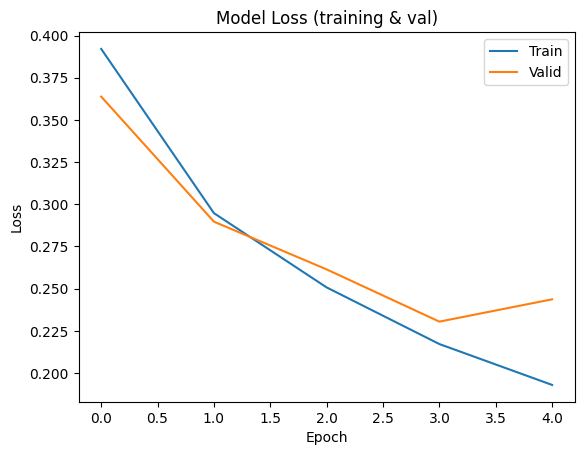

In [ ]:
# Evaluate with best weights
model.load_weights(filepath='model_best_weights.h5')
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

predicted_label = model.predict(test_ds)
true_label = test_ds.classes
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_label, predicted_label.round()), annot = True,fmt="d",cmap = "Greens")
plt.show()
metrics.accuracy_score(true_label, predicted_label.round())

from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming true_labels and predicted_labels are your true and predicted labels respectively
predicted_labels_rounded = predicted_label.round()  # Ensure predicted labels are rounded to 0 or 1

precision = precision_score(true_label, predicted_labels_rounded)
recall = recall_score(true_label, predicted_labels_rounded)
f1 = f1_score(true_label, predicted_labels_rounded)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

# MobileNet Training (Unfreeze 10 layers)

In [ ]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

base_model.trainable = False

for layer in base_model.layers[-10:]: # unfreeze the last 10 layers
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# from tensorflow.keras.layers import Dropout
# x = Dropout(0.5)(x)  # add a dropout layer
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), # lower the learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='model_best_weights.h5', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    train_ds,
    epochs=5,
    validation_data=valid_ds,
    callbacks=callbacks
)

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

Epoch 1/5
1563/1563 [==============================] - ETA: 0s - loss: 0.1875 - accuracy: 0.9245

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1563/1563 [==============================] - 309s 195ms/step - loss: 0.1875 - accuracy: 0.9245 - val_loss: 0.1728 - val_accuracy: 0.9337
Epoch 2/5
1563/1563 [==============================] - 305s 195ms/step - loss: 0.0921 - accuracy: 0.9646 - val_loss: 0.1450 - val_accuracy: 0.9428
Epoch 3/5
1563/1563 [==============================] - 316s 202ms/step - loss: 0.0662 - accuracy: 0.9753 - val_loss: 0.2655 - val_accuracy: 0.9176
Epoch 4/5
1563/1563 [==============================] - 312s 200ms/step - loss: 0.0526 - accuracy: 0.9801 - val_loss: 0.6478 - val_accuracy: 0.7861
Epoch 5/5
313/313 [==============================] - 46s 148ms/step - loss: 3.9369 - accuracy: 0.5260
Test accuracy: 0.525950014591217, Test loss: 3.936918258666992


# Use the saved best weights to test the trained model

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

base_model.trainable = False

for layer in base_model.layers[-10:]: # unfreeze the last 10 layers
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# from tensorflow.keras.layers import Dropout
# x = Dropout(0.5)(x)  # add a dropout layer
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), # lower the learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

17225924/17225924 [==============================] - 1s 0us/step


In [ ]:
files.upload()

Saving model_best_weights.h5 to model_best_weights.h5


In [ ]:
model.load_weights(filepath='model_best_weights.h5')
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

313/313 [==============================] - 57s 170ms/step - loss: 0.1416 - accuracy: 0.9413
Test Loss: 0.14161750674247742, Test Accuracy: 0.941349983215332


In [ ]:
predicted_label = model.predict(test_ds)

313/313 [==============================] - 46s 147ms/step


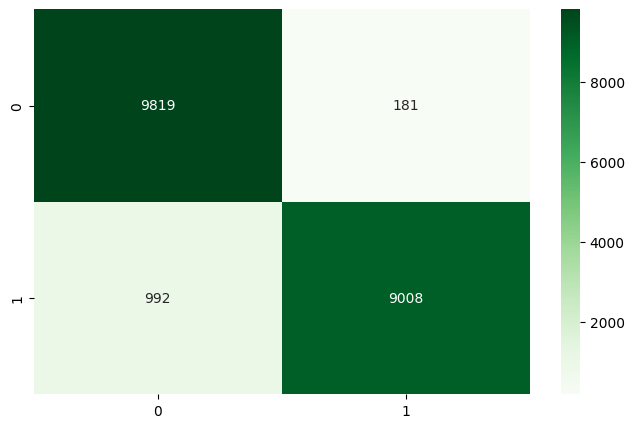

In [ ]:
true_label = test_ds.classes
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_label, predicted_label.round()), annot = True,fmt="d",cmap = "Greens")
plt.show()

In [ ]:
metrics.accuracy_score(true_label, predicted_label.round())

0.94135

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming true_labels and predicted_labels are your true and predicted labels respectively
predicted_labels_rounded = predicted_label.round()  # Ensure predicted labels are rounded to 0 or 1

precision = precision_score(true_label, predicted_labels_rounded)
recall = recall_score(true_label, predicted_labels_rounded)
f1 = f1_score(true_label, predicted_labels_rounded)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.9803025356404397
Recall: 0.9008
F1 Score: 0.9388712283078847


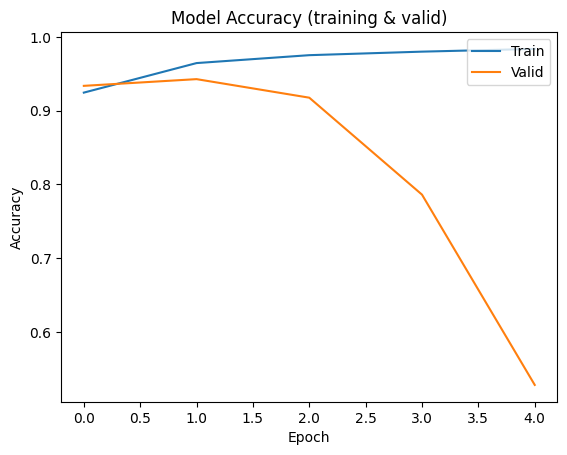

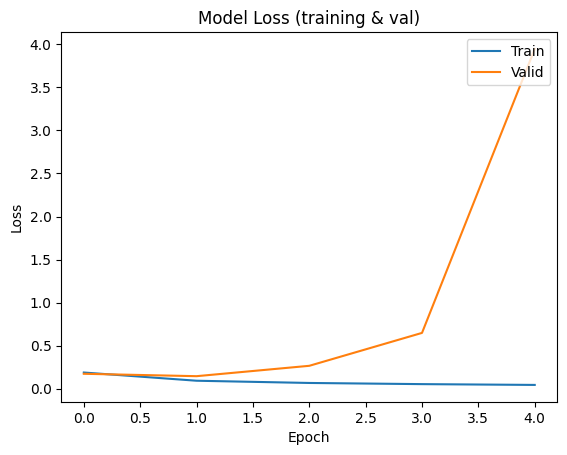

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

# Test the model using the cats dataset

The dataset consists of cats images generated by DALL-E models. You can find the dataset [here](https://www.kaggle.com/datasets/mattop/ai-cat-and-dog-images-dalle-mini).

We add a real cat image "mycat" in the dataset. You can find this image in the main directory of the github page.

In [ ]:
files.upload()

Saving Cats.zip to Cats.zip


{'Cats.zip': b'PK\x03\x04\x14\x00\x00\x00\x00\x00\xe7\x9d\x86X\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x00 \x00Cats/UT\r\x00\x07\x02\xdf\x11f\x02\xdf\x11f\x02\xdf\x11fux\x0b\x00\x01\x04\xf5\x01\x00\x00\x04\x14\x00\x00\x00PK\x03\x04\x14\x00\x08\x00\x08\x00\xf3\x9d\x86X\x00\x00\x00\x00\x00\x00\x00\x00\x04 \x00\x00\x0e\x00 \x00Cats/.DS_StoreUT\r\x00\x07\x1a\xdf\x11f\x02\xdf\x11f\x1a\xdf\x11fux\x0b\x00\x01\x04\xf5\x01\x00\x00\x04\x14\x00\x00\x00\xed\x99Oo\xd30\x18\xc6_weK\xe9\xfed\xdd\xca*\xe0\x10\xd1\x0b\xd2\x8ah\xc7\n\x9a\x90\xa0\xcb\x8a\xa0\xe2\xb0\xb1L\xa3S7J\xd2\xa4]\xb44.I\xba2\xaaI\xbb2>\xc0>\x00\x9f\x00!\x04W\x0e\\9rE\x88/\xc0\x8538\x8d[\xd2n+\xe22\x10\xf3O\x8a\x9e$\x8f\xdf\xd8\xafS\xdbr\n\x00H\xac\xab)\x80\x18\x00p\xe0)\x1f\x86#\xe1\xe8q\x88\x00\xd5\x11r \x12\x0fJ\xc3\xae)\x06V\xc8\xf5\xbb\xa3\x9f\xc5`0\x18\x0c\x06\xe3/\x83<\xe1\x8eY\xf7\x19\x0c\xc6)\xc6\x9d\x1f\x04\xaa\x19\xaa{\x9e"\xea\x07\xa8\x06}1<U\x81j\x86\xea\x9e\xa7\x88\x96\x0bP\rR\xe5\xa8\xf2T\x05\xaa\x19\xaa{

In [ ]:
!unzip Cats.zip

Archive:  Cats.zip
   creating: Cats/
  inflating: Cats/.DS_Store          
  inflating: __MACOSX/Cats/._.DS_Store  
   creating: Cats/real/
   creating: Cats/fake/
  inflating: Cats/real/mycat.jpeg    
  inflating: __MACOSX/Cats/real/._mycat.jpeg  
  inflating: Cats/fake/cat34.jpeg    
  inflating: __MACOSX/Cats/fake/._cat34.jpeg  
  inflating: Cats/fake/cat22.jpeg    
  inflating: __MACOSX/Cats/fake/._cat22.jpeg  
  inflating: Cats/fake/cat18.jpeg    
  inflating: __MACOSX/Cats/fake/._cat18.jpeg  
  inflating: Cats/fake/cat38.jpeg    
  inflating: __MACOSX/Cats/fake/._cat38.jpeg  
  inflating: Cats/fake/cat14.jpeg    
  inflating: __MACOSX/Cats/fake/._cat14.jpeg  
  inflating: Cats/fake/cat43.jpeg    
  inflating: __MACOSX/Cats/fake/._cat43.jpeg  
  inflating: Cats/fake/cat42.jpeg    
  inflating: __MACOSX/Cats/fake/._cat42.jpeg  
  inflating: Cats/fake/cat1.jpeg     
  inflating: __MACOSX/Cats/fake/._cat1.jpeg  
  inflating: Cats/fake/cat15.jpeg    
  inflating: __MACOSX/Cats/fake/.

In [ ]:
cats_dir = './Cats'

images_df = {
    "image_path":[],
    "label":[]
}

for label in os.listdir(cats_dir): #iterate on fake and real folders (labels)
    for img in glob.glob(cats_dir + "/" + label + "/*.jpeg"):
        images_df["image_path"].append(img)
        images_df["label"].append(label)
images_df = pd.DataFrame(images_df)
images_df

image_path label
0   ./Cats/fake/cat30.jpeg  fake
1   ./Cats/fake/cat23.jpeg  fake
2   ./Cats/fake/cat43.jpeg  fake
3   ./Cats/fake/cat20.jpeg  fake
4   ./Cats/fake/cat32.jpeg  fake
5   ./Cats/fake/cat18.jpeg  fake
6   ./Cats/fake/cat35.jpeg  fake
7   ./Cats/fake/cat37.jpeg  fake
8   ./Cats/fake/cat40.jpeg  fake
9   ./Cats/fake/cat33.jpeg  fake
10  ./Cats/fake/cat44.jpeg  fake
11  ./Cats/fake/cat49.jpeg  fake
12   ./Cats/fake/cat3.jpeg  fake
13  ./Cats/fake/cat15.jpeg  fake
14  ./Cats/fake/cat27.jpeg  fake
15  ./Cats/fake/cat25.jpeg  fake
16   ./Cats/fake/cat9.jpeg  fake
17  ./Cats/fake/cat34.jpeg  fake
18  ./Cats/fake/cat29.jpeg  fake
19   ./Cats/fake/cat4.jpeg  fake
20  ./Cats/fake/cat53.jpeg  fake
21  ./Cats/fake/cat36.jpeg  fake
22  ./Cats/fake/cat22.jpeg  fake
23  ./Cats/fake/cat31.jpeg  fake
24  ./Cats/fake/cat42.jpeg  fake
25   ./Cats/fake/cat5.jpeg  fake
26  ./Cats/fake/cat16.jpeg  fake
27  ./Cats/fake/cat17.jpeg  fake
28   ./Cats/fake/cat1.jpeg  fake
29  ./Cats/fake/cat14.jpeg  fake
30  ./Cats/fake/cat50.jpeg  fake
31  ./Cats/fake/cat46.jpeg  fake
32  ./Cats/fake/cat19.jpeg  fake
33   ./Cats/fake/cat8.jpeg  fake
34  ./Cats/fake/cat38.jpeg  fake
35  ./Cats/fake/cat51.jpeg  fake
36  ./Cats/fake/cat41.jpeg  fake
37   ./Cats/fake/cat7.jpeg  fake
38  ./Cats/fake/cat11.jpeg  fake
39  ./Cats/fake/cat10.jpeg  fake
40  ./Cats/fake/cat52.jpeg  fake
41  ./Cats/fake/cat45.jpeg  fake
42  ./Cats/fake/cat28.jpeg  fake
43   ./Cats/fake/cat2.jpeg  fake
44  ./Cats/fake/cat12.jpeg  fake
45  ./Cats/fake/cat21.jpeg  fake
46  ./Cats/fake/cat24.jpeg  fake
47  ./Cats/fake/cat54.jpeg  fake
48  ./Cats/fake/cat13.jpeg  fake
49  ./Cats/fake/cat47.jpeg  fake
50   ./Cats/fake/cat6.jpeg  fake
51  ./Cats/fake/cat26.jpeg  fake
52  ./Cats/fake/cat48.jpeg  fake
53  ./Cats/fake/cat39.jpeg  fake
54  ./Cats/real/mycat.jpeg  real

In [ ]:
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [ ]:
test_ds = image_gen.flow_from_directory(
    cats_dir,
    target_size=(256, 256),
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 55 images belonging to 2 classes.


In [ ]:
model.load_weights(filepath='model_best_weights.h5')
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

2/2 [==============================] - 0s 313ms/step - loss: 13.0456 - accuracy: 0.0182
Test Loss: 13.045625686645508, Test Accuracy: 0.0181818176060915


In [ ]:
predicted_labels = model.predict(test_ds)

2/2 [==============================] - 0s 47ms/step


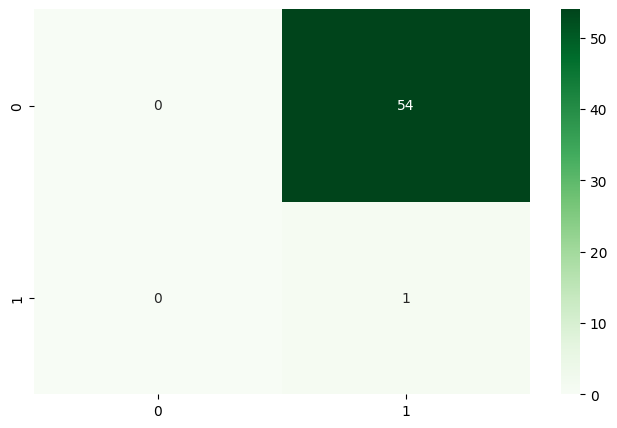

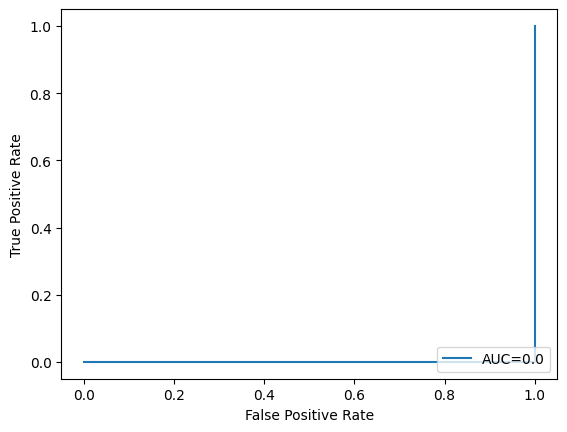

Precision: 0.01818181818181818
Recall: 1.0
F1 Score: 0.03571428571428572


In [ ]:
true_labels = test_ds.classes
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels.round()), annot = True,fmt="d",cmap = "Greens")
plt.show()
metrics.accuracy_score(true_labels, predicted_labels.round())
fpr, tpr, _ = metrics.roc_curve(true_labels,  predicted_labels)
auc = metrics.roc_auc_score(true_labels, predicted_labels)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Assuming true_labels and predicted_labels are your true and predicted labels respectively
predicted_labels_rounded = predicted_labels.round()  # Ensure predicted labels are rounded to 0 or 1

precision = precision_score(true_labels, predicted_labels_rounded)
recall = recall_score(true_labels, predicted_labels_rounded)
f1 = f1_score(true_labels, predicted_labels_rounded)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Testing on Stable Diffusion models

Fake images used here are collected [here](https://www.kaggle.com/datasets/bwandowando/faces-dataset-using-stable-diffusion-v14).

We manually combined it with some real images that you can find it [here](https://www.kaggle.com/datasets/atulanandjha/lfwpeople/data).

In [ ]:
files.upload()

Saving Stable Diffusion_Face.zip to Stable Diffusion_Face.zip


In [ ]:
!unzip "Stable Diffusion_Face"

Archive:  Stable Diffusion_Face.zip
   creating: Stable Diffusion_Face/
  inflating: Stable Diffusion_Face/.DS_Store  
  inflating: __MACOSX/Stable Diffusion_Face/._.DS_Store  
   creating: Stable Diffusion_Face/real/
   creating: Stable Diffusion_Face/fake/
  inflating: Stable Diffusion_Face/real/George_W_Bush_0434.jpg  
  inflating: __MACOSX/Stable Diffusion_Face/real/._George_W_Bush_0434.jpg  
  inflating: Stable Diffusion_Face/real/Vladimir_Putin_0012.jpg  
  inflating: __MACOSX/Stable Diffusion_Face/real/._Vladimir_Putin_0012.jpg  
  inflating: Stable Diffusion_Face/real/Gloria_Macapagal_Arroyo_0017.jpg  
  inflating: __MACOSX/Stable Diffusion_Face/real/._Gloria_Macapagal_Arroyo_0017.jpg  
  inflating: Stable Diffusion_Face/real/Silvio_Berlusconi_0005.jpg  
  inflating: __MACOSX/Stable Diffusion_Face/real/._Silvio_Berlusconi_0005.jpg  
  inflating: Stable Diffusion_Face/real/Nancy_Pelosi_0001.jpg  
  inflating: __MACOSX/Stable Diffusion_Face/real/._Nancy_Pelosi_0001.jpg  
  inflat

In [ ]:
sd_dir = './Stable Diffusion_Face'

images_df = {
    "image_path": [],
    "label": []
}

for label in os.listdir(sd_dir):  # iterate on fake and real folders (labels)
    if label == "fake":
        img_format = "*.png"
    elif label == "real":
        img_format = "*.jpg"
    else:
        continue  # Skip any folder that is not 'fake' or 'real'

    for img in glob.glob(os.path.join(sd_dir, label, img_format)):
        images_df["image_path"].append(img)
        images_df["label"].append(label)

images_df = pd.DataFrame(images_df)
print(images_df)


                                            image_path label
0    ./Stable Diffusion_Face/fake/seed_970409_00095...  fake
1    ./Stable Diffusion_Face/fake/seed_970417_00103...  fake
2    ./Stable Diffusion_Face/fake/seed_263159_00037...  fake
3    ./Stable Diffusion_Face/fake/seed_970424_00110...  fake
4    ./Stable Diffusion_Face/fake/seed_263219_00097...  fake
..                                                 ...   ...
295  ./Stable Diffusion_Face/real/Juan_Carlos_Ferre...  real
296  ./Stable Diffusion_Face/real/John_Ashcroft_002...  real
297  ./Stable Diffusion_Face/real/Vladimir_Putin_00...  real
298   ./Stable Diffusion_Face/real/Tony_Blair_0034.jpg  real
299  ./Stable Diffusion_Face/real/Nancy_Pelosi_0001...  real

[300 rows x 2 columns]


In [ ]:
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [ ]:
test_ds = image_gen.flow_from_directory(
    sd_dir,
    target_size=(256, 256),
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 300 images belonging to 2 classes.


In [ ]:
model.load_weights(filepath='model_best_weights.h5')
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

10/10 [==============================] - 3s 305ms/step - loss: 5.1740 - accuracy: 0.0833
Test Loss: 5.173984050750732, Test Accuracy: 0.0833333358168602


10/10 [==============================] - 3s 287ms/step


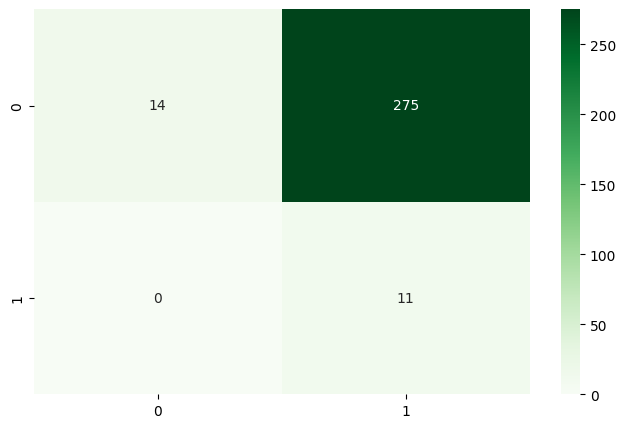

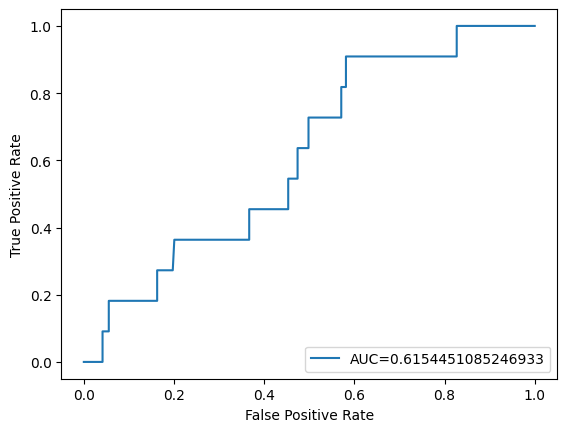

Precision: 0.038461538461538464
Recall: 1.0
F1 Score: 0.07407407407407407


In [ ]:
predicted_labels = model.predict(test_ds)
true_labels = test_ds.classes
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels.round()), annot = True,fmt="d",cmap = "Greens")
plt.show()
metrics.accuracy_score(true_labels, predicted_labels.round())
fpr, tpr, _ = metrics.roc_curve(true_labels,  predicted_labels)
auc = metrics.roc_auc_score(true_labels, predicted_labels)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Assuming true_labels and predicted_labels are your true and predicted labels respectively
predicted_labels_rounded = predicted_labels.round()  # Ensure predicted labels are rounded to 0 or 1

precision = precision_score(true_labels, predicted_labels_rounded)
recall = recall_score(true_labels, predicted_labels_rounded)
f1 = f1_score(true_labels, predicted_labels_rounded)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Test on GAN images

The Dataset we use here you can find [here](https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection).

In [ ]:
files.upload()

Saving GAN.zip to GAN.zip


In [ ]:
!unzip GAN.zip

Archive:  GAN.zip
   creating: GAN/
  inflating: __MACOSX/._GAN          
  inflating: GAN/.DS_Store           
  inflating: __MACOSX/GAN/._.DS_Store  
   creating: GAN/real/
  inflating: __MACOSX/GAN/._real     
   creating: GAN/fake/
  inflating: __MACOSX/GAN/._fake     
  inflating: GAN/real/real_00251.jpg  
  inflating: __MACOSX/GAN/real/._real_00251.jpg  
  inflating: GAN/real/real_00537.jpg  
  inflating: __MACOSX/GAN/real/._real_00537.jpg  
  inflating: GAN/real/real_00523.jpg  
  inflating: __MACOSX/GAN/real/._real_00523.jpg  
  inflating: GAN/real/real_00245.jpg  
  inflating: __MACOSX/GAN/real/._real_00245.jpg  
  inflating: GAN/real/real_00279.jpg  
  inflating: __MACOSX/GAN/real/._real_00279.jpg  
  inflating: GAN/real/real_00292.jpg  
  inflating: __MACOSX/GAN/real/._real_00292.jpg  
  inflating: GAN/real/real_00286.jpg  
  inflating: __MACOSX/GAN/real/._real_00286.jpg  
  inflating: GAN/real/real_00735.jpg  
  inflating: __MACOSX/GAN/real/._real_00735.jpg  
  inflating: G

In [ ]:
gan_dir = './GAN'

images_df = {
    "image_path":[],
    "label":[]
}

for label in os.listdir(gan_dir): #iterate on fake and real folders (labels)
    for img in glob.glob(gan_dir + "/" + label + "/*.jpg"):
        images_df["image_path"].append(img)
        images_df["label"].append(label)
images_df = pd.DataFrame(images_df)
images_df

image_path label
0     ./GAN/fake/easy_115_0010.jpg  fake
1      ./GAN/fake/mid_468_1110.jpg  fake
2      ./GAN/fake/mid_460_1111.jpg  fake
3     ./GAN/fake/easy_204_0101.jpg  fake
4     ./GAN/fake/hard_184_0011.jpg  fake
...                            ...   ...
2036     ./GAN/real/real_00730.jpg  real
2037     ./GAN/real/real_00917.jpg  real
2038     ./GAN/real/real_00614.jpg  real
2039     ./GAN/real/real_00481.jpg  real
2040     ./GAN/real/real_00096.jpg  real

[2041 rows x 2 columns]

In [ ]:
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [ ]:
test_ds = image_gen.flow_from_directory(
    gan_dir,
    target_size=(256, 256),
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 2041 images belonging to 2 classes.


In [ ]:
files.upload()

Saving model_best_weights2.h5 to model_best_weights2.h5


In [ ]:
model.load_weights(filepath='model_best_weights2.h5')
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

64/64 [==============================] - 19s 297ms/step - loss: 2.3213 - accuracy: 0.5326
Test Loss: 2.321274995803833, Test Accuracy: 0.5325820446014404


64/64 [==============================] - 18s 276ms/step


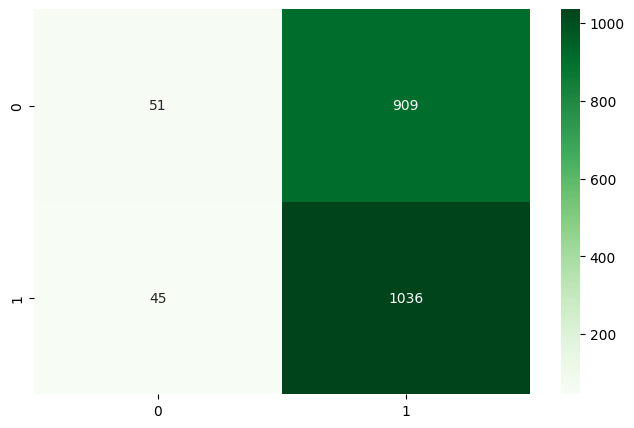

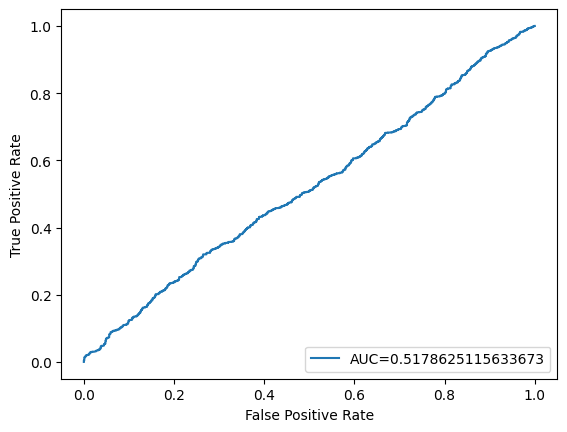

Precision: 0.5326478149100257
Recall: 0.9583718778908418
F1 Score: 0.6847323198942498


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

predicted_labels = model.predict(test_ds)
true_labels = test_ds.classes
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels.round()), annot = True,fmt="d",cmap = "Greens")
plt.show()
metrics.accuracy_score(true_labels, predicted_labels.round())
fpr, tpr, _ = metrics.roc_curve(true_labels,  predicted_labels)
auc = metrics.roc_auc_score(true_labels, predicted_labels)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Assuming true_labels and predicted_labels are your true and predicted labels respectively
predicted_labels_rounded = predicted_labels.round()  # Ensure predicted labels are rounded to 0 or 1

precision = precision_score(true_labels, predicted_labels_rounded)
recall = recall_score(true_labels, predicted_labels_rounded)
f1 = f1_score(true_labels, predicted_labels_rounded)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# See the basic info of this model

In [ ]:
def get_model(input_shape):

    input = tf.keras.Input(shape=input_shape)

    densenet = tf.keras.applications.DenseNet121( weights="imagenet", include_top=False, input_tensor = input)

    x = tf.keras.layers.GlobalAveragePooling2D()(densenet.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x) #binary classification

    model = tf.keras.Model(densenet.input, output)

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

In [ ]:
model_ft = get_model(input_shape)

model_ft.summary()

29084464/29084464 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.685918 to fit



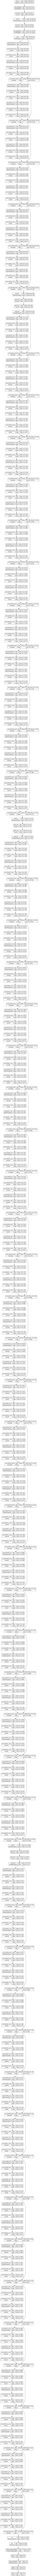

In [ ]:
tf.keras.utils.plot_model(model_ft, show_shapes=True)